README
1. Make sure to have the venv set up
    - Check to see Python 3.8 for python, pip, and jupyter version.
    - If not, then do the following:
        - Close the notebook.
        - In the notebook directory, delete the existing virtual env (might be hidden so use "ls -a" to find it)
        - Create a new one with the correct python version: virtualenv --python=python3.8 .venv
        - Use the venv: source .venv/bin/activate
        - Activate the venv as the kernel: python -m ipykernel install --user --name=.venv
        - Call jupyter notebook
        - Go to Kernel --> change kernel, and set to .venv
        - Ensure the python version and pip version are correct (ex. python3.8)
        - Ensure the notebook is using the right python version by calling: jupyter kernelspec list --json
2. Run the next cell, only if you need to install packages to the venv.
    - for fixing issues: https://jonathansoma.com/course/foundations-2021/jupyter-module-not-found/

In [ ]:
# Check python and pip version
#!python --version
#!pip --version

# Check Jupyter Python version
#!jupyter kernelspec list --json

# Requirements
#!pip install pandas
#!pip install numpy 
#!pip install datetime 
#!pip install matplotlib 
#!pip install sklearn 
#!pip install plotly 
#!pip install seaborn
#!pip install folium
#!pip install branca
#!pip install nbformat

# Check installed packages
!pip freeze 

In [166]:
import pandas as pd
import numpy as np
from datetime import datetime, timezone
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.cluster import KMeans
from sklearn import preprocessing
import plotly.express as px
import seaborn
import folium
from folium import plugins
import branca.colormap as cm
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

In [131]:
# Load data
data1 = pd.read_csv('./run-S3bucket_node3-1-part-r-00000', low_memory=False)
data2 = pd.read_csv('./run-S3bucket_node3-1-part-r-00001', low_memory=False)
data_raw = pd.concat([data1,data2], ignore_index=True)

In [132]:
# Removing unecessary columns
data = data_raw[['ride_id','service_name','origin_latitude', 'origin_longitude','destination_latitude', 'destination_longitude',
             'rider_username','capacity', 'status', 'terminal_reason', 'created_at', 'duration', 'wait_time',
             'completed_at', 'canceled_by', 'driver', 'vehicle']]


In [155]:
## Transformations
# Feature Eng:
# 1) *Add weather data
# 2) Distance per trip 
# *Optional

data_t = data

# Transform the “Created_at” variable that is a string into a datetime then into an integer representing 
# the time in hours. Do the same for the “Completed_at” variable.
dates = data_t.created_at.values
data_t['created_at_est'] = data_t.created_at.apply(lambda x: x[0:-5])
data_t['created_at_est'] = pd.to_datetime(data_t.created_at_est)

dates = data_t.created_at.values
data_t['completed_at_est'] = data_t.completed_at.apply(lambda x: x[0:-5])
data_t['completed_at_est'] = pd.to_datetime(data_t.completed_at_est)

# Create a new variable called “Week_day” that is an integer representing the days of the week 
# (0-monday, 1-tuesday, … 7-sunday) by taking the “Created_at” variable, which is a string, 
# and changing it to a datetime.
data_t['week_day_num'] = data_t['created_at_est'].dt.dayofweek
days_of_week = {0:"Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 4: "Friday", 5: "Saturday", 6: "Sunday"}
data_t['week_day'] = data_t.week_day_num.apply(lambda x: days_of_week[x])

data_t['hour'] = data_t['created_at_est'].dt.hour

data_t['date_only'] = data_t.created_at.apply(lambda x: pd.to_datetime(x).date())

# Number of current shuttles opperating [vehicle]
df = data_t.groupby(['date_only', 'hour'])['vehicle'].nunique()
df = df.to_frame()
df.reset_index(inplace=True)
df.columns = ['date_only', 'hour','num_shuttles_per_hour']
data_t = pd.merge(data_t, df, on=['date_only', 'hour'])

data_t = data_t[data_t.service_name.apply(lambda x: x in ['Homewood Night Ride','Homewood and Peabody Night Ride'])]

data_t['duration'] = data_t.duration.apply(lambda x: x / 60)

In [135]:
# Removing unecessary columns
data = data_t[['ride_id', 'service_name', 'origin_latitude', 'origin_longitude',
       'destination_latitude', 'destination_longitude',
       'capacity', 'status', 'terminal_reason', 'created_at',
       'wait_time', 'completed_at', 'canceled_by', 'vehicle',
       'created_at_est', 'week_day', 'hour', 'date_only',
       'num_shuttles_per_hour', 'completed_at_est', 'duration']]

display(data)

ride_id                     service_name  origin_latitude  \
0       6908763  Homewood and Peabody Night Ride        39.325899   
1       6908747  Homewood and Peabody Night Ride        39.334933   
2       6908783  Homewood and Peabody Night Ride        39.327372   
3       6908751  Homewood and Peabody Night Ride        39.318563   
4       6908729  Homewood and Peabody Night Ride        39.338570   
...         ...                              ...              ...   
221512  7576679              Homewood Night Ride        39.330272   
221513  8614973              Homewood Night Ride        39.335112   
221514  8614975              Homewood Night Ride        39.335479   
221515  8614983              Homewood Night Ride        39.327444   
221516  8614997              Homewood Night Ride        39.336544   

        origin_longitude  destination_latitude  destination_longitude  \
0             -76.621523             39.337467             -76.641797   
1             -76.620442             39.324952             -76.613596   
2             -76.619396             39.324382             -76.616121   
3             -76.614497             39.333032             -76.631247   
4             -76.635212             39.339193             -76.609297   
...                  ...                   ...                    ...   
221512        -76.624704             39.309859             -76.618041   
221513        -76.621521             39.336651             -76.618508   
221514        -76.622151             39.330449             -76.615876   
221515        -76.615872             39.334109             -76.618304   
221516        -76.618518             39.326616             -76.616048   

        capacity    status terminal_reason                     created_at  \
0              1  complete             NaN  2020-08-03 23:32:37.000 UTC-4   
1              2  complete             NaN  2020-08-03 23:14:51.000 UTC-4   
2              1  complete             NaN  2020-08-03 23:43:58.000 UTC-4   
3              1  complete             NaN  2020-08-03 23:16:01.000 UTC-4   
4              1  complete             NaN  2020-08-03 23:01:05.000 UTC-4   
...          ...       ...             ...                            ...   
221512         1  complete             NaN  2020-12-29 01:47:03.000 UTC-5   
221513         1  complete             NaN  2021-06-24 01:16:54.000 UTC-4   
221514         1  complete             NaN  2021-06-24 01:17:55.000 UTC-4   
221515         1  complete             NaN  2021-06-24 01:22:36.000 UTC-4   
221516         1  complete             NaN  2021-06-24 01:42:27.000 UTC-4   

        ...                   completed_at canceled_by vehicle  \
0       ...  2020-08-03 23:44:37.000 UTC-4         NaN   960.0   
1       ...  2020-08-03 23:24:43.000 UTC-4         NaN   942.0   
2       ...  2020-08-03 23:57:53.000 UTC-4         NaN   973.0   
3       ...  2020-08-03 23:32:04.000 UTC-4         NaN   960.0   
4       ...  2020-08-03 23:14:56.000 UTC-4         NaN   960.0   
...     ...                            ...         ...     ...   
221512  ...  2020-12-29 01:56:25.000 UTC-5         NaN   980.0   
221513  ...  2021-06-24 01:25:05.000 UTC-4         NaN   960.0   
221514  ...  2021-06-24 01:28:31.000 UTC-4         NaN   960.0   
221515  ...  2021-06-24 01:31:45.000 UTC-4         NaN   990.0   
221516  ...  2021-06-24 01:54:35.000 UTC-4         NaN   971.0   

            created_at_est  week_day hour   date_only num_shuttles_per_hour  \
0      2020-08-03 23:32:37    Monday   23  2020-08-03                     6   
1      2020-08-03 23:14:51    Monday   23  2020-08-03                     6   
2      2020-08-03 23:43:58    Monday   23  2020-08-03                     6   
3      2020-08-03 23:16:01    Monday   23  2020-08-03                     6   
4      2020-08-03 23:01:05    Monday   23  2020-08-03                     6   
...                    ...       ...  ...         ...                   ...   
221512 2020-12-29 01:47:03   Tu

In [158]:
'''
Rides Origin and Destination analysis Transloc service provides a clustering of ride locations aggregated by a range of days.
Our analysis should cluster ride locations by time of the day and day of the week. 
- Input: hour of the day and/or day of the week
- Information display: Scatter plot, x is longitude and y is latitude. Then, overlay image with map. 
'''

def day_hour_filter(data_df, using_day, using_hour, day, hour):
    X_df = []
    if using_day:
        # only using day
        X_df = data_df[data_df['week_day_num'] == day]
        if using_hour:
            # using both day and hour
            X_df = X_df[X_df['hour'] == hour]
    else: # only using hour
        X_df = data_df[data_df['hour'] == hour]
        
    return X_df

'''def day_hour_range_filter(data_df, using_day, using_hour, day, hour_start, hour_end):
    X_df = []
    if using_day:
        # only using day
        X_df = data_df[data_df['week_day_num'] == day]
        if using_hour:
            # using both day and hour
            X_df = X_df[X_df['hour'] >= hour_start and X_df['hour'] <= hour_end]
    else: # only using hour
        X_df = data_df[data_df['hour'] >= hour_start and data_df['hour'] <= hour_end]
    return X_df'''

"def day_hour_range_filter(data_df, using_day, using_hour, day, hour_start, hour_end):\n    X_df = []\n    if using_day:\n        # only using day\n        X_df = data_df[data_df['week_day_num'] == day]\n        if using_hour:\n            # using both day and hour\n            X_df = X_df[X_df['hour'] >= hour_start and X_df['hour'] <= hour_end]\n    else: # only using hour\n        X_df = data_df[data_df['hour'] >= hour_start and data_df['hour'] <= hour_end]\n    return X_df"

In [159]:
# Determine K: Elbow method

def get_k(X, k_max):
    k_num = k_max
    sse = [] # A list holds the SSE values for each k
    for k in range(1, k_num):
        if len(X) < k:
            break
        kmeans = KMeans(n_clusters=k, n_init=100)
        kmeans.fit(X)
        sse.append(kmeans.inertia_)
        
    if len(X) < 1:
        return 0

    scaler = preprocessing.MinMaxScaler()
    normalized_sse = scaler.fit_transform(np.array(sse).reshape(-1,1))
    normalized_k_num = scaler.fit_transform(np.array(range(1, k_num)).reshape(-1,1))

    '''plt.plot(range(1, k_num), normalized_sse*k_num) #range(1, k_num), sse
    plt.xticks(range(1, k_num))
    plt.xlabel("Number of Clusters")
    plt.ylabel("SSE")
    plt.grid()
    plt.show()'''
    
    k = None
    for i in range(len(normalized_k_num)-1):
        if (normalized_sse[i+1] - normalized_sse[i]) / (normalized_k_num[i+1] - normalized_k_num[i]) > -0.5:
            k = range(1,k_num)[i]
            break
    #print(k)
    return k

In [164]:
def get_folium_map(coord, kmeans_model, cluster_labels, 
                   use_folium_cluster=True, use_kmeans_cluster=True, use_kmeans_centroids=True):
    this_map = folium.Map(location=[39.3299, -76.6205], zoom_start=12)

    if use_folium_cluster:
        # Plot folium density cluster (not kmeans)
        this_map.add_child(
            plugins.MarkerCluster(
                locations=list(zip(coord[:,0],coord[:,1])), 
                popups=[str(e) for e in cluster_labels]
            ) 
        )
    
    if use_kmeans_cluster:
        # Plot locations labeled by sklearn kmeans cluster
        colors = ['red', 'blue', 'green', 'purple', 'orange','white', 'pink', 'gray','black']
        cluster_labels_ = np.unique(np.array(cluster_labels))
        
        counter = 0
        while counter < 10 and len(cluster_labels_) > len(colors):
            counter = counter +1
            colors.extend(['red', 'blue', 'green', 'purple', 'orange','white', 'pink', 'gray','black'])
            
        colormap = cm.StepColormap(colors= colors[0:len(cluster_labels_)],
                                   index=cluster_labels_)
        for loc, p in zip(zip(coord[:,0], coord[:,1]),cluster_labels):
              folium.Circle(
                  location=loc,
                  radius=1, 
                  fill=True, 
                  color=colormap(p)
            ).add_to(this_map)

    if use_kmeans_centroids:
        # Plot kmeans cluster centroids
        C = list(zip(kmeans_model.cluster_centers_[:,0], kmeans_model.cluster_centers_[:,1]))
        for i in range(len(C)):
            folium.Marker(
                  location=C[i]
            ).add_to(this_map)

    #Set the zoom to the maximum possible
    this_map.fit_bounds(this_map.get_bounds())
    
    display(this_map)
    
# Note:
# Folium alternative: https://plotly.com/python/scattermapbox/

In [161]:
def get_clusters(data, using_day, using_hour, day, hour, columns, k=None):
    columns.append("ride_id")
    
    X = day_hour_filter(data, using_day, using_hour, day, hour)[columns]
    #X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)
    X_coord_only = X[columns[:-1]].values # columns[:-1] is to get rid of "ride_id" added in prev line.

    # Train model
    if k is None:
        k = get_k(X_coord_only, 30)
    kmeans = KMeans(init='k-means++', n_clusters=k, n_init=100)
    kmeans.fit(X_coord_only)

    # Predictions and Model Evaluation
    #pred = kmeans.predict(X_test)

    # TODO: Save information in df
    data_clustered_df = X
    data_clustered_df['cluster'] = kmeans.labels_
    
    return data_clustered_df, kmeans

Use clustering to determine how to segment the map. Then in each segment we can analyze the demand and supply to determine how many shuttles should be supplied to bring supply and demand for all segments to near equal. 


In [179]:
# 0) Cluster origin and destination data separately binned by [day of week, hour]
cluster_dest_df, cluster_dest_model = get_clusters(data, True, True, 3, 1, 
                                             ["origin_latitude", "origin_longitude"])
cluster_origin_df, cluster_origin_model = get_clusters(data, True, True, 4, 1, 
                                             ["origin_latitude", "origin_longitude"])

In [181]:
# Display map
print("[Destination] K-Means Clustering of pick up locations (2020-08-03 to 2021-09-29) (thur, 1 am)")
get_folium_map(coord=cluster_dest_df[["origin_latitude", "origin_longitude"]].values, 
               kmeans_model=cluster_dest_model, 
               cluster_labels=cluster_dest_df['cluster'].values, 
               use_folium_cluster=True, use_kmeans_cluster=True, use_kmeans_centroids=True)

print("[Origin] K-Means Clustering of pick up locations (2020-08-03 to 2021-09-29) (fri, 1 am)")
get_folium_map(coord=cluster_origin_df[["origin_latitude", "origin_longitude"]].values, 
               kmeans_model=cluster_origin_model, 
               cluster_labels=cluster_origin_df['cluster'].values, 
               use_folium_cluster=True, use_kmeans_cluster=True, use_kmeans_centroids=True)

[Destination] K-Means Clustering of pick up locations (2020-08-03 to 2021-09-29) (thur, 1 am)


[Origin] K-Means Clustering of pick up locations (2020-08-03 to 2021-09-29) (fri, 1 am)


In [170]:
# Get Data: friday at hour 19
cluster_origin_df, cluster_origin_model = get_clusters(data, True, True, 4, 23, 
                                             ["origin_latitude", "origin_longitude"])
cluster_dest_df, cluster_dest_model = get_clusters(data, True, True, 5, 1, 
                                             ['destination_latitude', 'destination_longitude'])

In [ ]:
# Display map
print("[Origin] K-Means Clustering of pick up locations (2020-08-03 to 2021-09-29) (friday, no hour)")
get_folium_map(coord=cluster_origin_df[["origin_latitude", "origin_longitude"]].values, 
               kmeans_model=cluster_origin_model, 
               cluster_labels=cluster_origin_df['cluster'].values, 
               use_folium_cluster=True, use_kmeans_cluster=True, use_kmeans_centroids=True)

print("[Destination] K-Means Clustering of drop off locations (2020-08-03 to 2021-09-29) (friday, no hour)")
get_folium_map(coord=cluster_dest_df[['destination_latitude', 'destination_longitude']].values, 
               kmeans_model=cluster_dest_model, 
               cluster_labels=cluster_dest_df['cluster'].values, 
               use_folium_cluster=True, use_kmeans_cluster=True, use_kmeans_centroids=True)

In [13]:
"""Features
id:         'ride_id', 'vehicle'
categories: 'service_name', 'status', 'terminal_reason', 'canceled_by'
coord:      'origin_latitude', 'origin_longitude', 'destination_latitude', 'destination_longitude',
continuous: 'capacity', 'created_at', 'duration', 'wait_time', 'completed_at','created_at_est', 'week_day', 'hour', 
            'date_only', 'num_shuttles_per_hour', completed_at_est

Note: use import seaborn as sns
          import plotly.express as px
"""

"Features\nid:         'ride_id', 'vehicle'\ncategories: 'service_name', 'status', 'terminal_reason', 'canceled_by'\ncoord:      'origin_latitude', 'origin_longitude', 'destination_latitude', 'destination_longitude',\ncontinuous: 'capacity', 'created_at', 'duration', 'wait_time', 'completed_at','created_at_est', 'week_day', 'hour', \n            'date_only', 'num_shuttles_per_hour'\n\nNote: use import seaborn as sns\n          import plotly.express as px\n"

In [83]:
# 1) Demand of Shuttles binned by [month, day of week, hour, cluster], maybe also by [service_name]
data_ = data[['service_name','capacity', 'week_day', 'hour']]
data_ = data_.groupby(['week_day', 'hour', 'service_name'])['capacity'].sum() #mean()
data_ = data_.to_frame()
data_.reset_index(inplace=True)
data_.columns = ['week_day', 'hour','service_name','requested_capacity']

for service in ['Homewood Night Ride','Homewood and Peabody Night Ride']:
    fig=px.scatter(data_[data_['service_name'] == service],
                x='hour',
                y='requested_capacity',
                color='week_day',
                template='plotly_dark')
    fig.update_layout(title_text='Requested capacity per hour for ' + service, title_x=0.5)
    fig.show()

<AxesSubplot:xlabel='created_at_est,created_at_est'>

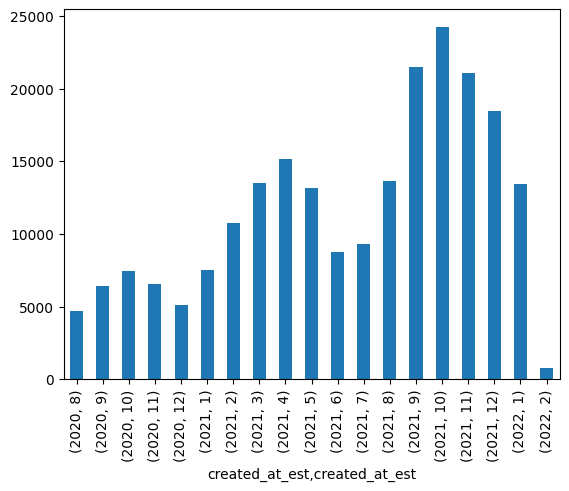

In [15]:
data['ride_id'].groupby([data["created_at_est"].dt.year, data["created_at_est"].dt.month]).count().plot(kind="bar")

In [ ]:
# 2) Supply [number of active shuttles and number of pickups] of Shuttles binned by 
#    [month, day of week, hour, cluster], maybe also by [service_name]
data_ = data[['service_name','capacity', 'week_day', 'hour', 'status']]
data_ = data_[data_['status'] == 'complete']
data_ = data_.groupby(['week_day', 'hour', 'service_name'])['capacity'].sum()
data_ = data_.to_frame()
data_.reset_index(inplace=True)
data_.columns = ['week_day', 'hour','service_name','picked_up_capacity']
for service in ['Homewood Night Ride','Homewood and Peabody Night Ride']:
    fig=px.scatter(data_[data_['service_name'] == service],
                x='hour',
                y='picked_up_capacity',
                color='week_day',
                template='plotly_dark')
    fig.update_layout(title_text='Picked up capacity per hour for ' + service, title_x=0.5)
    fig.show()
    
data_ = data[['service_name', 'week_day', 'hour', 'vehicle']]
data_ = data_.groupby(['week_day', 'hour', 'service_name'])['vehicle'].nunique()
data_ = pd.DataFrame(data_)
data_.reset_index(inplace=True)
data_.columns = ['week_day', 'hour','service_name','num_shuttles_per_hour']
for service in ['Homewood Night Ride','Homewood and Peabody Night Ride']:
    fig=px.scatter(data_[data_['service_name'] == service],
                x='hour',
                y='num_shuttles_per_hour',
                color='week_day',
                template='plotly_dark')
    fig.update_layout(title_text='Number of Shuttles per hour for ' + service, title_x=0.5)
    fig.show()

In [ ]:
# 3) Number of cancelations binned by [day of week, hour, cluster], maybe also by [service_name]
#print(np.unique(data.status.values))
#print(np.unique([str(x) for x in data.canceled_by.values]))
data_ = data[['service_name','capacity', 'week_day', 'hour', 'status','canceled_by']]
data_ = data_[data_['status'] == 'canceled']
data_ = data_.groupby(['week_day', 'hour', 'service_name','canceled_by'])['capacity'].sum()
data_ = data_.to_frame()
data_.reset_index(inplace=True)
data_.columns = ['week_day', 'hour','service_name','canceled_by','canceled_capacity']

for service in ['Homewood Night Ride','Homewood and Peabody Night Ride']:
    data_temp = data_[data_['service_name'] == service]
    data_temp = data_temp[data_temp['canceled_by'] == 'dispatcher']
    fig=px.scatter(data_temp,
                x='hour',
                y='canceled_capacity',
                color='week_day',
                template='plotly_dark')
    fig.update_layout(title_text='Canceled capacity by Dispatcher per hour for ' + service, title_x=0.5)
    fig.show()
    
for service in ['Homewood Night Ride','Homewood and Peabody Night Ride']:
    data_temp = data_[data_['service_name'] == service]
    data_temp = data_temp[data_temp['canceled_by'] == 'user']
    fig=px.scatter(data_temp,
                x='hour',
                y='canceled_capacity',
                color='week_day',
                template='plotly_dark')
    fig.update_layout(title_text='Canceled capacity by User per hour for ' + service, title_x=0.5)
    fig.show()

In [ ]:
# 4) Covariance matrix of [capacity, duration, wait_time, num_shuttles_per_hour] stratified by [status, canceled_by]
data_ = data[['capacity', 'duration', 'wait_time', 'num_shuttles_per_hour', 'status', 'canceled_by']]
cov = data_[['capacity', 'duration', 'wait_time', 'num_shuttles_per_hour']].cov()
corr = data_[['capacity', 'duration', 'wait_time', 'num_shuttles_per_hour']].corr()
fig = px.imshow(cov, text_auto=True)
fig.show()
fig = px.imshow(corr, text_auto=True)
fig.show()

In [ ]:
# 5) Plot [duration, wait_time] binned by [status, day of week, hours, cluster], maybe also by [service_name]
data_ = data[['duration', 'wait_time', 'week_day', 'hour', 'service_name']]

df = px.data.tips()
fig = px.scatter(data_, x="wait_time", y="duration", color="hour", facet_col="week_day")
fig.show()

In [ ]:
# 6) Supervised learning (Classification): given [origin_latitude, origin_longitude, destination_latitude, 
#    destination_longitude, capacity, week_day, hour, num_shuttles_per_hour], predict [status] = complete or canceled
data_t = data[['origin_latitude', 'origin_longitude', 'destination_latitude', 'destination_longitude', 'capacity', 
              'week_day_num', 'hour', 'num_shuttles_per_hour', 'status']]
data_t = data_t[data_t.status.apply(lambda x: x in ['canceled','complete'])]
X = data_t[[#'origin_latitude', 'origin_longitude', 'destination_latitude', 'destination_longitude', 
            'capacity', 'week_day_num', 'hour', 'num_shuttles_per_hour']]
y = data_t['status']

# Test train split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

# Logistic # score = 0.71
logisticRegr = LogisticRegression()
logisticRegr.fit(x_train, y_train)
predictions = logisticRegr.predict(x_test)

score = logisticRegr.score(x_test, y_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
seaborn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);

# Naive Bayes # score = 0.71
'''GNBclf = GaussianNB()
GNBclf.fit(x_train, y_train)
predictions = GNBclf.predict(x_test)

score = GNBclf.score(x_test, y_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
seaborn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);'''

# SVM score = 0.71
'''clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(X, y)
predictions = clf.predict(x_test)

score = GNBclf.score(x_test, y_test)
cm = metrics.confusion_matrix(y_test, predictions)
plt.figure(figsize=(9,9))
seaborn.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15);'''

In [128]:
# 7) Supervised learning (Regression): given [origin_latitude, origin_longitude, destination_latitude, 
#    destination_longitude, capacity, week_day, hour, num_shuttles_per_hour], predict [completed_at] 
#    (ensure completed_at = duration + wait_time)
data_t = data[['origin_latitude', 'origin_longitude', 'destination_latitude', 'destination_longitude', 'capacity', 
              'week_day_num', 'hour', 'num_shuttles_per_hour', 'duration', 'wait_time', 'status']]
data_t = data_t[data_t['status']=='complete']
X = data_t[[#'origin_latitude', 'origin_longitude', 'destination_latitude', 'destination_longitude', 
            'capacity', 'week_day_num', 'hour', 'num_shuttles_per_hour']]
y = data_t['wait_time']

# Test train split
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)


# Linear Regression
linreg = LinearRegression()
linreg.fit(X, y)
predictions = linreg.predict(x_test)

score = linreg.score(x_test, y_test)
print(score)

0.02061656570644177


In [22]:
# 8) *Relationship between weather and demand.
